In [1]:
import pandas as pd
import os
import subprocess
import zipfile
import matplotlib.pyplot as plt
from itertools import chain
from sklearn.model_selection import GroupKFold
import lightgbm as lgb
import numpy as np

“Dado um conjunto de voos apresentados a um usuário, qual é o mais provável que ele selecione?”

É um problema clássico de:

-Aprendizado supervisionado

-Com objetivo de ranking

-E grupos estruturados (ranker_id)

HitRate@3
Você acerta se o voo real (selected = 1) estiver entre os 3 primeiros ranks do seu modelo para cada grupo com mais de 10 opções.



Principais perguntas:

- Qual é a média de opções de voo por sessão aberta
- A quantidade de opções de voo impactam na decisão do cliente? Mais opções, mais compras?
- Quantas sessões que eu não tive nenhuma compra


In [2]:
pd.reset_option("all")
pd.set_option('display.max_columns', None)

C:\Users\lpl_z\AppData\Local\Temp\ipykernel_696\3427858977.py:1: FutureWarning: data_manager option is deprecated and will be removed in a future version. Only the BlockManager will be available.
  pd.reset_option("all")
C:\Users\lpl_z\AppData\Local\Temp\ipykernel_696\3427858977.py:1: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.reset_option("all")


In [3]:
def download_files():
    # utilizando a API do kaggle para download
    # adicionado a /data no git ignore
    # Define caminhos
    zip_path = "data/aeroclub-recsys-2025.zip"
    extract_path = "data/aeroclub"
    
    # Cria a pasta base se necessário
    os.makedirs("data", exist_ok=True)

    # Verifica se o arquivo .zip já foi baixado
    if not os.path.exists(zip_path):
        print("🔽 Baixando arquivos da competição...")
        subprocess.run([
            "kaggle", "competitions", "download",
            "-c", "aeroclub-recsys-2025",
            "-p", "data"
        ])
    else:
        print("✅ Arquivo ZIP já existe. Pulando download.")

    # Verifica se os arquivos já foram extraídos
    if not os.path.exists(extract_path) or not os.listdir(extract_path):
        print("📦 Extraindo arquivos...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
    else:
        print("✅ Arquivos já extraídos. Pulando extração.")

# Executa
download_files()

✅ Arquivo ZIP já existe. Pulando download.
✅ Arquivos já extraídos. Pulando extração.


In [4]:
def reduce_memory_usage(df):
    for col in df.columns:
        col_type = df[col].dtypes
        
        if col_type == 'float64':
            df[col] = pd.to_numeric(df[col], downcast='float')
        elif col_type == 'int64':
            df[col] = pd.to_numeric(df[col], downcast='integer')
        elif col_type == 'object':
            num_unique = df[col].nunique()
            num_total = len(df[col])
            if num_unique / num_total < 0.5:
                df[col] = df[col].astype('category')
    
    return df

In [5]:
train = pd.read_parquet("data/aeroclub/train.parquet")

In [6]:
#df_train_raw = reduce_memory_usage(train)
df_train_raw = train.copy()

In [7]:
# Define as colunas que você quer manter
columns_to_keep = [
    # Identifiers
    'Id',  # num
    'ranker_id', 
    'profileId', 
    'companyID',
    
    # User info
    'sex', 'nationality', 'frequentFlyer', 'isVip', 'bySelf', 'isAccess3D',

    # Company info
    'corporateTariffCode',

    # Search & route
    'searchRoute', 'requestDate',

    # Pricing
    'totalPrice', 'taxes',

    # Flight timing
    'legs0_departureAt', 'legs0_arrivalAt', 'legs0_duration',
    'legs1_departureAt', 'legs1_arrivalAt', 'legs1_duration',

    # Segment-level info (só do segmento 0 da ida para simplificar no baseline)
    'legs0_segments0_departureFrom_airport_iata',
    'legs0_segments0_arrivalTo_airport_iata',
    'legs0_segments0_arrivalTo_airport_city_iata',
    'legs0_segments0_marketingCarrier_code',
    'legs0_segments0_operatingCarrier_code',
    'legs0_segments0_aircraft_code',
    'legs0_segments0_flightNumber',
    'legs0_segments0_duration',
    'legs0_segments0_baggageAllowance_quantity',
    'legs0_segments0_baggageAllowance_weightMeasurementType',
    'legs0_segments0_cabinClass',
    'legs0_segments0_seatsAvailable',

    # Cancellation & exchange rules
    'miniRules0_monetaryAmount', 'miniRules0_percentage', 'miniRules0_statusInfos',
    'miniRules1_monetaryAmount', 'miniRules1_percentage', 'miniRules1_statusInfos',

    # Pricing policy
    'pricingInfo_isAccessTP', 'pricingInfo_passengerCount',

    # Target
    'selected'
]

# Filtra os dados para o baseline
rows_to_copy = 18_000_000
df_train = df_train_raw[columns_to_keep].iloc[:].copy()

# Garante que o ranker_id está em string
df_train['ranker_id'] = df_train['ranker_id'].astype(str)


In [8]:
def fix_column_types(df):
    df_fixed = df.copy()
    for col in df.columns:
        if isinstance(df[col].dtype, pd.CategoricalDtype):
            # Tenta converter para tipo numérico
            try:
                df_fixed[col] = pd.to_numeric(df[col])
            except:
                # Se não for numérico, tenta bool
                unique_vals = df[col].dropna().unique()
                if set(unique_vals) <= {True, False}:
                    df_fixed[col] = df[col].astype(bool)
                else:
                    df_fixed[col] = df[col].astype(str)
    return df_fixed
df_train = fix_column_types(df_train)
df_train.dtypes  # Checar resultado


Id                                                                 int64
ranker_id                                                         object
profileId                                                          int64
companyID                                                          int64
sex                                                                 bool
nationality                                                        Int64
frequentFlyer                                                     object
isVip                                                               bool
bySelf                                                              bool
isAccess3D                                                          bool
corporateTariffCode                                                Int64
searchRoute                                                       object
requestDate                                               datetime64[ns]
totalPrice                                         

In [9]:
# 🗓️ Colunas de datas e horários
cols_datetime = [
    'requestDate',
    'legs0_departureAt', 'legs0_arrivalAt',
    'legs1_departureAt', 'legs1_arrivalAt'
]

def process_datetime_and_duration(df):
    df_processed = df.copy()

    for col in cols_datetime:
        df_processed[col] = pd.to_datetime(df_processed[col], errors='coerce')

    # 📆 Features derivadas de datas
    df_processed['legs0_dep_hour'] = df_processed['legs0_departureAt'].dt.hour
    df_processed['legs0_dep_dayofweek'] = df_processed['legs0_departureAt'].dt.dayofweek
    df_processed['legs1_dep_hour'] = df_processed['legs1_departureAt'].dt.hour
    df_processed['trip_days'] = (df_processed['legs1_departureAt'] - df_processed['legs0_departureAt']).dt.days
    df_processed['booking_to_trip_days'] = (df_processed['legs0_departureAt'] - df_processed['requestDate']).dt.days

    # ⏱️ Função segura para converter duração para minutos
    def clean_and_convert_duration(col):
        return (
            col
            .fillna("00:00:00")
            .astype(str)
            .str.strip()
            .str.replace("nan", "00:00:00")
            .pipe(pd.to_timedelta, errors='coerce')
            .dt.total_seconds() / 60  # minutos
        )

    # ⏳ Colunas de duração
    cols_duration = ['legs0_duration', 'legs1_duration']
    for col in cols_duration:
        df_processed[col] = clean_and_convert_duration(df_processed[col])

    return df_processed

# ✅ Exemplo de uso:
df_train = process_datetime_and_duration(df_train)
df_train[['legs0_duration', 'trip_days', 'legs0_dep_hour']].head()

,legs0_duration,trip_days,legs0_dep_hour
0,160.0,23.0,15
1,445.0,24.0,9
2,445.0,24.0,9
3,445.0,24.0,9
4,445.0,24.0,9


In [10]:
df_train.drop(columns=cols_datetime, inplace=True)

In [11]:
df_train.head()

,Id,ranker_id,profileId,companyID,sex,nationality,frequentFlyer,isVip,bySelf,isAccess3D,corporateTariffCode,searchRoute,totalPrice,taxes,legs0_duration,legs1_duration,legs0_segments0_departureFrom_airport_iata,legs0_segments0_arrivalTo_airport_iata,legs0_segments0_arrivalTo_airport_city_iata,legs0_segments0_marketingCarrier_code,legs0_segments0_operatingCarrier_code,legs0_segments0_aircraft_code,legs0_segments0_flightNumber,legs0_segments0_duration,legs0_segments0_baggageAllowance_quantity,legs0_segments0_baggageAllowance_weightMeasurementType,legs0_segments0_cabinClass,legs0_segments0_seatsAvailable,miniRules0_monetaryAmount,miniRules0_percentage,miniRules0_statusInfos,miniRules1_monetaryAmount,miniRules1_percentage,miniRules1_statusInfos,pricingInfo_isAccessTP,pricingInfo_passengerCount,selected,legs0_dep_hour,legs0_dep_dayofweek,legs1_dep_hour,trip_days,booking_to_trip_days
0,0,98ce0dabf6964640b63079fbafd42cbe,2087645,57323,True,36,S7/SU/UT,False,True,False,<NA>,TLKKJA/KJATLK,16884.0,370.0,160.0,155.0,TLK,KJA,KJA,KV,KV,YK2,216,02:40:00,1.0,0.0,1.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,1,15,5,9.0,23.0,29
1,1,98ce0dabf6964640b63079fbafd42cbe,2087645,57323,True,36,S7/SU/UT,False,True,True,123,TLKKJA/KJATLK,51125.0,2240.0,445.0,505.0,TLK,OVB,OVB,S7,S7,E70,5358,02:50:00,1.0,0.0,1.0,4.0,2300.0,NaN,1.0,3500.0,NaN,1.0,1.0,1,0,9,5,22.0,24.0,29
2,2,98ce0dabf6964640b63079fbafd42cbe,2087645,57323,True,36,S7/SU/UT,False,True,False,<NA>,TLKKJA/KJATLK,53695.0,2240.0,445.0,505.0,TLK,OVB,OVB,S7,S7,E70,5358,02:50:00,1.0,0.0,1.0,4.0,2300.0,NaN,1.0,3500.0,NaN,1.0,1.0,1,0,9,5,22.0,24.0,29
3,3,98ce0dabf6964640b63079fbafd42cbe,2087645,57323,True,36,S7/SU/UT,False,True,True,123,TLKKJA/KJATLK,81880.0,2240.0,445.0,505.0,TLK,OVB,OVB,S7,S7,E70,5358,02:50:00,1.0,0.0,1.0,4.0,0.0,NaN,1.0,0.0,NaN,1.0,1.0,1,0,9,5,22.0,24.0,29
4,4,98ce0dabf6964640b63079fbafd42cbe,2087645,57323,True,36,S7/SU/UT,False,True,False,<NA>,TLKKJA/KJATLK,86070.0,2240.0,445.0,505.0,TLK,OVB,OVB,S7,S7,E70,5358,02:50:00,1.0,0.0,1.0,4.0,0.0,NaN,1.0,0.0,NaN,1.0,1.0,1,0,9,5,22.0,24.0,29


In [12]:
df_train

,Id,ranker_id,profileId,companyID,sex,nationality,frequentFlyer,isVip,bySelf,isAccess3D,corporateTariffCode,searchRoute,totalPrice,taxes,legs0_duration,legs1_duration,legs0_segments0_departureFrom_airport_iata,legs0_segments0_arrivalTo_airport_iata,legs0_segments0_arrivalTo_airport_city_iata,legs0_segments0_marketingCarrier_code,legs0_segments0_operatingCarrier_code,legs0_segments0_aircraft_code,legs0_segments0_flightNumber,legs0_segments0_duration,legs0_segments0_baggageAllowance_quantity,legs0_segments0_baggageAllowance_weightMeasurementType,legs0_segments0_cabinClass,legs0_segments0_seatsAvailable,miniRules0_monetaryAmount,miniRules0_percentage,miniRules0_statusInfos,miniRules1_monetaryAmount,miniRules1_percentage,miniRules1_statusInfos,pricingInfo_isAccessTP,pricingInfo_passengerCount,selected,legs0_dep_hour,legs0_dep_dayofweek,legs1_dep_hour,trip_days,booking_to_trip_days
0,0,98ce0dabf6964640b63079fbafd42cbe,2087645,57323,True,36,S7/SU/UT,False,True,False,<NA>,TLKKJA/KJATLK,16884.0,370.0,160.0,155.0,TLK,KJA,KJA,KV,KV,YK2,216,02:40:00,1.0,0.0,1.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,1,15,5,9.0,23.0,29
1,1,98ce0dabf6964640b63079fbafd42cbe,2087645,57323,True,36,S7/SU/UT,False,True,True,123,TLKKJA/KJATLK,51125.0,2240.0,445.0,505.0,TLK,OVB,OVB,S7,S7,E70,5358,02:50:00,1.0,0.0,1.0,4.0,2300.0,NaN,1.0,3500.0,NaN,1.0,1.0,1,0,9,5,22.0,24.0,29
2,2,98ce0dabf6964640b63079fbafd42cbe,2087645,57323,True,36,S7/SU/UT,False,True,False,<NA>,TLKKJA/KJATLK,53695.0,2240.0,445.0,505.0,TLK,OVB,OVB,S7,S7,E70,5358,02:50:00,1.0,0.0,1.0,4.0,2300.0,NaN,1.0,3500.0,NaN,1.0,1.0,1,0,9,5,22.0,24.0,29
3,3,98ce0dabf6964640b63079fbafd42cbe,2087645,57323,True,36,S7/SU/UT,False,True,True,123,TLKKJA/KJATLK,81880.0,2240.0,445.0,505.0,TLK,OVB,OVB,S7,S7,E70,5358,02:50:00,1.0,0.0,1.0,4.0,0.0,NaN,1.0,0.0,NaN,1.0,1.0,1,0,9,5,22.0,24.0,29
4,4,98ce0dabf6964640b63079fbafd42cbe,2087645,57323,True,36,S7/SU/UT,False,True,False,<NA>,TLKKJA/KJATLK,86070.0,2240.0,445.0,505.0,TLK,OVB,OVB,S7,S7,E70,5358,02:50:00,1.0,0.0,1.0,4.0,0.0,NaN,1.0,0.0,NaN,1.0,1.0,1,0,9,5,22.0,24.0,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18146427,18146427,88f8c53a28bf4f438941fd67338009e8,3046852,54154,True,36,None,False,True,True,44,MOWSVX/SVXMOW,30730.0,5560.0,655.0,885.0,VKO,SGC,SGC,UT,UT,738,247,03:20:00,0.0,0.0,1.0,3.0,24000.0,NaN,1.0,0.0,NaN,0.0,0.0,1,0,20,1,19.0,3.0,7
18146428,18146428,88f8c53a28bf4f438941fd67338009e8,3046852,54154,True,36,None,False,True,True,44,MOWSVX/SVXMOW,27660.0,5560.0,1060.0,805.0,VKO,UFA,UFA,UT,UT,738,363,02:05:00,0.0,0.0,1.0,3.0,24000.0,NaN,1.0,0.0,NaN,0.0,0.0,1,0,0,1,21.0,4.0,6
18146429,18146429,88f8c53a28bf4f438941fd67338009e8,3046852,54154,True,36,None,False,True,True,44,MOWSVX/SVXMOW,24460.0,5460.0,1060.0,885.0,VKO,UFA,UFA,UT,UT,738,363,02:05:00,0.0,0.0,1.0,3.0,24000.0,NaN,1.0,0.0,NaN,0.0,0.0,1,0,0,1,19.0,4.0,6
18146430,18146430,88f8c53a28bf4f438941fd67338009e8,3046852,54154,True,36,None,False,True,True,44,MOWSVX/SVXMOW,25360.0,5560.0,1180.0,805.0,VKO,KUF,KUF,UT,UT,738,357,01:45:00,0.0,0.0,1.0,4.0,24000.0,NaN,1.0,0.0,NaN,0.0,0.0,1,0,19,1,21.0,4.0,7


In [13]:
df_train.columns[:20]

Index(['Id', 'ranker_id', 'profileId', 'companyID', 'sex', 'nationality',
       'frequentFlyer', 'isVip', 'bySelf', 'isAccess3D', 'corporateTariffCode',
       'searchRoute', 'totalPrice', 'taxes', 'legs0_duration',
       'legs1_duration', 'legs0_segments0_departureFrom_airport_iata',
       'legs0_segments0_arrivalTo_airport_iata',
       'legs0_segments0_arrivalTo_airport_city_iata',
       'legs0_segments0_marketingCarrier_code'],
      dtype='object')

In [14]:
group_sizes = df_train.groupby('ranker_id').size()
group_sizes.describe()

count    105539.000000
mean        171.930490
std         445.940118
min           1.000000
25%          19.000000
50%          50.000000
75%         154.000000
max        8236.000000
dtype: float64

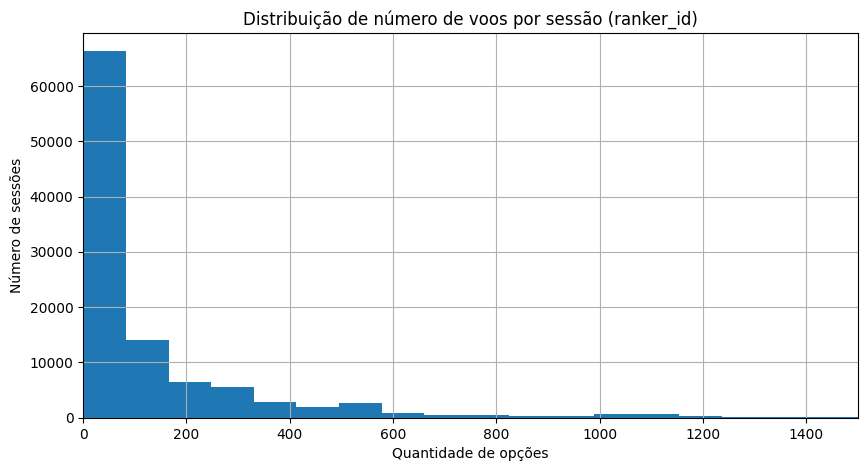

In [15]:
group_sizes.hist(bins=100, figsize=(10, 5))
plt.title("Distribuição de número de voos por sessão (ranker_id)")
plt.xlabel("Quantidade de opções")
plt.ylabel("Número de sessões")
plt.xlim(0, 1500)  # Limita o eixo X para melhor visualização
plt.grid(True)
plt.show()


In [16]:
df_resume = df_train[['ranker_id', 'selected']].groupby('ranker_id').sum()
df_resume = df_resume.reset_index()

In [17]:
df_resume.sort_values(by='selected', ascending=False)

,ranker_id,selected
105538,ffffb2f91f8c43cba68e87edf3782eeb,1
0,00004b95a9e446b586c5e9b729714447,1
1,0002078fb9aa4c3db9bdc24e0ca41a2d,1
105522,fff4907eeb8b438c8fa06c4496b2a4b8,1
105521,fff46c1887e04a6cb59907ea16f2ad68,1
...,...,...
7,0007b80d3f5c47d4bf9d7fe219164551,1
6,0006882ec40342519d8375a2214e0247,1
5,0005d546794e4b8e865e18be31f9e052,1
4,0005372bdc234a5faec2d8791240d9f3,1


In [18]:
df_resume.count()

ranker_id    105539
selected     105539
dtype: int64

In [19]:
print("💰 Preço médio voo escolhido:", df_train['totalPrice'].mean())
print("💸 Preço médio voo não escolhido:", df_train['totalPrice'].mean())

💰 Preço médio voo escolhido: 46314.43764815072
💸 Preço médio voo não escolhido: 46314.43764815072


In [20]:
#df_selected

In [21]:
def count_frequent_flyers(value):
    if pd.isna(value):
        return 0
    return len(str(value).split('/'))

df_train['frequentFlyer_count'] = df_train['frequentFlyer'].apply(count_frequent_flyers)

In [22]:
# Converte string de tempo para timedelta e depois para minutos
df_train['legs0_duration_minutes'] = pd.to_timedelta(df_train['legs0_duration'], errors='coerce').dt.total_seconds() / 60
# Cria flag binária para frequent flyer
df_train['hasFrequentFlyer'] = df_train['frequentFlyer'].notnull().astype(int)
# Separar escolhidos e não escolhidos
df_selected = df_train[df_train['selected'] == 1]
df_not_selected = df_train[df_train['selected'] == 0]

# Variáveis corrigidas para comparação
features = {
    'totalPrice': '💰 Preço total',
    'taxes': '💸 Taxas',
    'legs0_duration_minutes': '⏱️ Duração (minutos)',
    'frequentFlyer_count': '🛫Quantidade Frequent Flyer',
    'isVip': '👑 VIP',
    'pricingInfo_isAccessTP': '✅ Segue política',
    'legs0_segments0_cabinClass': '💺 Classe do voo (ida - seg. 0)',
}

# Montar a tabela de médias
comparison = []

for col, label in features.items():
    s1 = pd.to_numeric(df_selected[col], errors='coerce')
    s0 = pd.to_numeric(df_not_selected[col], errors='coerce')
    
    mean_selected = s1.mean()
    mean_not_selected = s0.mean()
    diff = mean_selected - mean_not_selected
    
    comparison.append({
        '🔹 Variável': label,
        'Escolhido (1)': round(mean_selected, 2),
        'Não escolhido (0)': round(mean_not_selected, 2),
        'Diferença': round(diff, 2)
    })

# Criar DataFrame de comparação
df_comparison = pd.DataFrame(comparison)

# Exibir a tabela formatada
print("\n📊 Comparação de médias entre voos escolhidos e não escolhidos:\n")
print(df_comparison.to_string(index=False))



📊 Comparação de médias entre voos escolhidos e não escolhidos:

                    🔹 Variável  Escolhido (1)  Não escolhido (0)  Diferença
                 💰 Preço total       27381.38           46425.20  -19043.82
                       💸 Taxas        2087.97            4297.55   -2209.58
          ⏱️ Duração (minutos)           0.00               0.00      -0.00
    🛫Quantidade Frequent Flyer           0.51               0.51       0.01
                         👑 VIP           0.05               0.05      -0.00
              ✅ Segue política           0.78               0.50       0.29
💺 Classe do voo (ida - seg. 0)           1.06               1.21      -0.15


In [23]:
df_comparison

,🔹 Variável,Escolhido (1),Não escolhido (0),Diferença
0,💰 Preço total,27381.38,46425.20,-19043.82
1,💸 Taxas,2087.97,4297.55,-2209.58
2,⏱️ Duração (minutos),0.00,0.00,-0.00
3,🛫Quantidade Frequent Flyer,0.51,0.51,0.01
4,👑 VIP,0.05,0.05,-0.00
5,✅ Segue política,0.78,0.50,0.29
6,💺 Classe do voo (ida - seg. 0),1.06,1.21,-0.15


In [24]:
df_train['legs0_duration']

0            160.0
1            445.0
2            445.0
3            445.0
4            445.0
             ...  
18146427     655.0
18146428    1060.0
18146429    1060.0
18146430    1180.0
18146431    1180.0
Name: legs0_duration, Length: 18145372, dtype: float64

In [25]:
df_train['frequentFlyer'] = df_train['frequentFlyer'].astype(str)

In [26]:
df_train['frequentFlyer'].unique()

array(['S7/SU/UT', 'None', 'S7', 'SU', 'UT/SU', 'UT', 'S7/SU/UT/U6',
       'SU/N4', 'SU/S7', 'N4/SU/DP', 'SU/TK', 'S7/SU/ET/EK', 'S7/UT/SU',
       'SU/S7/UT', 'UT/SU/S7', 'SU/U6/S7', 'SU/UT/S7', 'SU/SU', 'SU/UT',
       'LH', 'SU/KC/LH/S7', 'UT/S7/SU', 'S7/SU', 'SU/U6', 'S7/S7',
       'SU/S7/5N/U6/N4', 'UT/S7', 'SU/S7/U6', 'SU/S7/Y7', 'SU/LH',
       'S7/SU/U6', 'S7/SU/R3', 'S7/2G', 'SU/TK/EY/HY', 'SU/S7/TK/OS',
       'KC/SU/S7', 'SU/S7/LH/UT', 'SU/FV', 'SU/S7/UT/Y7', 'DV',
       'UT/S7/SU/ET', 'S7/EK', 'SU/TK/KC', 'TK', 'SU/5N', 'LH/SU',
       'SU/UT/S7/LH', 'SU/S7/A4/N4/UT/U6', 'SU/S7/DP/UT', 'SU/EK',
       'SU/S7/SU', 'S7/UT', 'AF', 'SU/S7/UT/LH/U6/EK', 'SU/S7/U6/DP',
       'U6', 'SU/S7/TK', 'SU/S7/TK/Y7/N4', 'Y7/SU', 'SU/UT/S7/EY',
       'SU/S7/LH', 'UT/UT/SU', 'S7/SU/UT/LH', 'SU/R3/UT/S7/Y7',
       'SU/S7/UT/N4/U6', 'SU/U6/UT', 'SU/BA', 'SU/TK/EK/S7',
       'SU/TK/EK/AZ', 'S7/EK/GF', 'TK/SU/EK', 'SU/TK/S7/N4',
       'SU/S7/UT/U6', 'U6/SU/N4', 'SU/S7/UT/I8', 'SU/EK/LH/S

In [27]:
# Substituir valores NaN por string vazia
ff_series = df_train['frequentFlyer'].fillna('').astype(str)

# Dividir por '/' para obter lista
ff_lists = ff_series.str.split('/')

all_programs = set(chain.from_iterable(ff_lists))
print(f"Total de companhias únicas: {len(all_programs)}")


Total de companhias únicas: 71


In [28]:
for program in all_programs:
    if program == '':
        continue  # pula string vazia
    df_train[f'ff_{program}'] = ff_lists.apply(lambda x: int(program in x))

for col in df_train.columns:
    if col.startswith("ff_"):
        df_train[col] = df_train[col].astype(pd.BooleanDtype())

In [29]:
df_train.drop('frequentFlyer', axis=1, inplace=True)

In [30]:
df_train['nationality'].unique()

<IntegerArray>
[36,  6, 21, 46,  8, 23, 10, 45, 28,  3, 38, 19,  1, 26, 34,  0, 47, 12, 16,
 37, 44, 25, 39, 31, 43, 32, 14,  4, 24,  5, 29, 17, 48, 30,  7, 42,  9, 27,
 41, 15, 13, 35, 33, 18,  2, 40, 22, 11]
Length: 48, dtype: Int64

In [31]:
df_train['searchRoute']

0           TLKKJA/KJATLK
1           TLKKJA/KJATLK
2           TLKKJA/KJATLK
3           TLKKJA/KJATLK
4           TLKKJA/KJATLK
                ...      
18146427    MOWSVX/SVXMOW
18146428    MOWSVX/SVXMOW
18146429    MOWSVX/SVXMOW
18146430    MOWSVX/SVXMOW
18146431    MOWSVX/SVXMOW
Name: searchRoute, Length: 18145372, dtype: object

In [32]:
df_train["nationality"] = df_train["nationality"].astype("str")

In [33]:
df_train["searchRoute"] = df_train["searchRoute"].astype("str")

In [34]:

df_train['legs0_segments0_duration']

0           02:40:00
1           02:50:00
2           02:50:00
3           02:50:00
4           02:50:00
              ...   
18146427    03:20:00
18146428    02:05:00
18146429    02:05:00
18146430    01:45:00
18146431    01:45:00
Name: legs0_segments0_duration, Length: 18145372, dtype: object

In [35]:
df_train['legs0_segments0_duration']

0           02:40:00
1           02:50:00
2           02:50:00
3           02:50:00
4           02:50:00
              ...   
18146427    03:20:00
18146428    02:05:00
18146429    02:05:00
18146430    01:45:00
18146431    01:45:00
Name: legs0_segments0_duration, Length: 18145372, dtype: object

In [36]:
df_train['legs0_segments0_duration'] = (
    pd.to_timedelta(
        df_train['legs0_segments0_duration'].fillna("00:00:00").astype(str).str.strip(),
        errors='coerce'
    ).dt.total_seconds() / 60  # em minutos
)

In [37]:
cols_cat = [
    'legs0_segments0_departureFrom_airport_iata',
    'legs0_segments0_arrivalTo_airport_iata',
    'legs0_segments0_arrivalTo_airport_city_iata',
    'legs0_segments0_marketingCarrier_code',
    'legs0_segments0_operatingCarrier_code',
    'legs0_segments0_aircraft_code'
]

for col in cols_cat:
    df_train[col] = df_train[col].astype('str')

In [38]:
pd.set_option('display.max_columns', None)  # Mostra todas as colunas
pd.set_option('display.max_rows', 100)      # Limite de linhas visíveis (ajuste se quiser)
pd.set_option('display.max_colwidth', None) # Mostra conteúdo completo de colunas

#pd.reset_option('display.max_columns')
#pd.reset_option('display.max_rows')
#pd.reset_option('display.max_colwidth')

In [39]:
df_train.dtypes  # Checar resultado

Id             int64
ranker_id     object
profileId      int64
companyID      int64
sex             bool
              ...   
ff_U6        boolean
ff_OZ        boolean
ff_OK        boolean
ff_S7        boolean
ff_LH        boolean
Length: 115, dtype: object

In [40]:
df_train['pricingInfo_isAccessTP'].unique()

array([ 1.,  0., nan])

In [41]:
df_train['hasFrequentFlyer'].unique()

array([1, 0])

In [42]:
bool_cols = [
    'pricingInfo_isAccessTP',
    'hasFrequentFlyer',
]

for col in bool_cols:
    df_train[col] = df_train[col].astype('boolean')

In [43]:
df_train.dtypes  # Checar resultado

Id             int64
ranker_id     object
profileId      int64
companyID      int64
sex             bool
              ...   
ff_U6        boolean
ff_OZ        boolean
ff_OK        boolean
ff_S7        boolean
ff_LH        boolean
Length: 115, dtype: object

In [45]:
# --- Target e grupo
target_col = "selected"
group_col = "ranker_id"

# --- Categóricas para LightGBM
categorical_cols = [
    'nationality',
    'searchRoute',
    'legs0_segments0_departureFrom_airport_iata',
    'legs0_segments0_arrivalTo_airport_iata',
    'legs0_segments0_arrivalTo_airport_city_iata',
    'legs0_segments0_marketingCarrier_code',
    'legs0_segments0_operatingCarrier_code',
    'legs0_segments0_aircraft_code',
    'corporateTariffCode'
]

# --- Booleanas e numéricas
boolean_cols = [
    'sex', 'isVip', 'bySelf', 'isAccess3D', 'pricingInfo_isAccessTP', 'hasFrequentFlyer'
] + [col for col in df_train.columns if col.startswith("ff_")]

numeric_cols = [
    'totalPrice', 'taxes', 'legs0_duration', 'legs1_duration',
    'legs0_segments0_duration', 'legs0_segments0_baggageAllowance_quantity',
    'legs0_segments0_baggageAllowance_weightMeasurementType',
    'legs0_segments0_cabinClass', 'legs0_segments0_seatsAvailable',
    'miniRules0_monetaryAmount', 'miniRules0_percentage',
    'miniRules1_monetaryAmount', 'miniRules1_percentage',
    'booking_to_trip_days', 'trip_days', 'legs0_dep_hour',
    'legs1_dep_hour', 'frequentFlyer_count', 'legs0_duration_minutes'
]

features = numeric_cols + categorical_cols + boolean_cols

# --- Converte categóricas para category
for col in categorical_cols:
    df_train[col] = df_train[col].astype("category")

# --- Split com GroupShuffleSplit
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(gss.split(df_train, groups=df_train["ranker_id"]))

df_train_split = df_train.iloc[train_idx].copy()
df_val = df_train.iloc[val_idx].copy()  # << IMPORTANTE

X_train = df_train_split[features]
y_train = df_train_split[target_col]
groups_train = df_train_split[group_col].value_counts().sort_index().values

X_val = df_val[features]
y_val = df_val[target_col]
groups_val = df_val[group_col].value_counts().sort_index().values

# --- LightGBM Dataset
import lightgbm as lgb

train_dataset = lgb.Dataset(X_train, y_train, group=groups_train, categorical_feature=categorical_cols)
val_dataset = lgb.Dataset(X_val, y_val, group=groups_val, categorical_feature=categorical_cols, reference=train_dataset)

# --- Parâmetros
params = {
    "objective": "lambdarank",
    "metric": "ndcg",
    "ndcg_eval_at": [3],
    "learning_rate": 0.05,
    "num_leaves": 31,
    "min_data_in_leaf": 20,
    "verbosity": -1,
}

# --- Treinamento com early stopping
model = lgb.train(
    params,
    train_dataset,
    valid_sets=[train_dataset, val_dataset],
    valid_names=["train", "valid"],
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(stopping_rounds=50)],
    #verbose_eval=50
)

# --- Predição
y_pred = model.predict(X_val)

# --- Avaliação Top-1
df_pred = df_val.copy()
df_pred['y_true'] = y_val
df_pred['y_pred'] = y_pred

df_pred_sorted = df_pred.sort_values(['ranker_id', 'y_pred'], ascending=[True, False])
df_top1 = df_pred_sorted.groupby('ranker_id').head(1)

acertos = df_top1['y_true'].sum()
total = df_top1.shape[0]

print(f"Voos escolhidos corretamente (top1): {acertos} de {total} sessões")
print(f"Acurácia top1: {acertos / total:.4f}")


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[995]	train's ndcg@3: 0.871285	valid's ndcg@3: 0.827899
Voos escolhidos corretamente (top1): 7085 de 21108 sessões
Acurácia top1: 0.3357


In [46]:
# 1. Ler test.parquet
df_test = pd.read_parquet("data/aeroclub/test.parquet")

# 2. Aplicar as transformações mínimas necessárias

# Convertendo tipos
df_test['ranker_id'] = df_test['ranker_id'].astype(str)
df_test['nationality'] = df_test['nationality'].astype(str)
df_test['searchRoute'] = df_test['searchRoute'].astype(str)

# Frequent Flyer (cria os mesmos one-hot da base de treino)
df_test['frequentFlyer'] = df_test['frequentFlyer'].fillna('').astype(str)
ff_lists_test = df_test['frequentFlyer'].str.split('/')
for program in all_programs:
    if program == '':
        continue
    df_test[f'ff_{program}'] = ff_lists_test.apply(lambda x: program in x)

# Tipos booleanos
for col in [col for col in df_test.columns if col.startswith("ff_")]:
    df_test[col] = df_test[col].astype(pd.BooleanDtype())

# Outras variáveis derivadas
df_test['frequentFlyer_count'] = df_test['frequentFlyer'].apply(count_frequent_flyers)
df_test['hasFrequentFlyer'] = df_test['frequentFlyer'].notnull().astype(int)
df_test.drop(columns=['frequentFlyer'], inplace=True)

# Datas
cols_datetime = [
    'requestDate',
    'legs0_departureAt', 'legs0_arrivalAt',
    'legs1_departureAt', 'legs1_arrivalAt'
]
for col in cols_datetime:
    df_test[col] = pd.to_datetime(df_test[col], errors='coerce')

df_test['legs0_dep_hour'] = df_test['legs0_departureAt'].dt.hour
df_test['legs0_dep_dayofweek'] = df_test['legs0_departureAt'].dt.dayofweek
df_test['legs1_dep_hour'] = df_test['legs1_departureAt'].dt.hour
df_test['trip_days'] = (df_test['legs1_departureAt'] - df_test['legs0_departureAt']).dt.days
df_test['booking_to_trip_days'] = (df_test['legs0_departureAt'] - df_test['requestDate']).dt.days
df_test.drop(columns=cols_datetime, inplace=True)

# Duração
def clean_and_convert_duration(col):
    return (
        col
        .fillna("00:00:00")
        .astype(str)
        .str.strip()
        .str.replace("nan", "00:00:00")
        .pipe(pd.to_timedelta, errors='coerce')
        .dt.total_seconds() / 60
    )
df_test['legs0_duration'] = clean_and_convert_duration(df_test['legs0_duration'])
df_test['legs1_duration'] = clean_and_convert_duration(df_test['legs1_duration'])
df_test['legs0_segments0_duration'] = clean_and_convert_duration(df_test['legs0_segments0_duration'])
df_test['legs0_duration_minutes'] = df_test['legs0_duration']  # mesmo valor

# Corrigir categoricals
for col in categorical_cols:
    df_test[col] = df_test[col].astype("category")

# Corrigir booleanos
for col in ['sex', 'isVip', 'bySelf', 'isAccess3D', 'pricingInfo_isAccessTP', 'hasFrequentFlyer']:
    df_test[col] = df_test[col].astype("boolean")

# 3. Prever com o modelo
X_test = df_test[features]
df_test['y_pred'] = model.predict(X_test)

# 4. Gerar submissão com ranking por ranker_id
df_test_sorted = df_test.sort_values(['ranker_id', 'y_pred'], ascending=[True, False])
df_test_sorted['selected'] = df_test_sorted.groupby('ranker_id').cumcount() + 1

submission = df_test_sorted[['Id', 'ranker_id', 'selected']]
submission.to_csv("submission.csv", index=False)
print("✅ Arquivo de submissão salvo como 'submission.csv'")


✅ Arquivo de submissão salvo como 'submission.csv'
